In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm

In [16]:
# 1. Portfolio Construction Functions
def create_portfolio(assets, weights, investment_amount):
    """
    Create a portfolio with given assets and weights
    
    Parameters:
    -----------
    assets : dict
        Dictionary with asset names as keys and their current prices as values
    weights : dict
        Dictionary with asset names as keys and their allocation weights as values
    investment_amount : float
        Total investment amount
    
    Returns:
    --------
    dict
        Portfolio details including holdings, weights, and invested amount
    """
    portfolio = {
        "assets": assets,
        "weights": weights,
        "holdings": {},
        "total_value": investment_amount
    }
    
    # Calculate holdings based on weights
    for asset, weight in weights.items():
        if asset not in assets:
            raise ValueError(f"Asset {asset} not found in asset list")
        
        amount_to_invest = investment_amount * weight
        units = amount_to_invest / assets[asset]
        
        portfolio["holdings"][asset] = {
            "price": assets[asset],
            "units": units,
            "value": amount_to_invest
        }
    
    return portfolio

In [17]:
def calculate_portfolio_value(portfolio, new_prices=None):
    """
    Calculate portfolio value based on current or new prices
    
    Parameters:
    -----------
    portfolio : dict
        Portfolio details from create_portfolio function
    new_prices : dict, optional
        Dictionary with asset names as keys and their new prices as values
    
    Returns:
    --------
    float
        New portfolio value
    """
    total_value = 0
    
    for asset, holding in portfolio["holdings"].items():
        price = new_prices[asset] if new_prices and asset in new_prices else holding["price"]
        value = holding["units"] * price
        total_value += value
        
    return total_value

In [18]:
# 2. Stress Testing Functions
def create_stress_scenario(assets, scenario_name, price_changes):
    """
    Create a stress scenario with specified price changes
    
    Parameters:
    -----------
    assets : dict
        Dictionary with asset names as keys and their current prices as values
    scenario_name : str
        Name of the stress scenario
    price_changes : dict
        Dictionary with asset names as keys and their percentage changes as values
    
    Returns:
    --------
    dict
        Stress scenario details
    """
    scenario = {
        "name": scenario_name,
        "price_changes": price_changes,
        "new_prices": {}
    }
    
    for asset, price in assets.items():
        change = price_changes.get(asset, 0)  # Default to 0% change if not specified
        scenario["new_prices"][asset] = price * (1 + change/100)
    
    return scenario

In [19]:
def apply_stress_scenario(portfolio, scenario):
    """
    Apply a stress scenario to a portfolio
    
    Parameters:
    -----------
    portfolio : dict
        Portfolio details from create_portfolio function
    scenario : dict
        Stress scenario details from create_stress_scenario function
    
    Returns:
    --------
    dict
        Results of applying the stress scenario
    """
    original_value = portfolio["total_value"]
    new_value = calculate_portfolio_value(portfolio, scenario["new_prices"])
    
    return {
        "scenario": scenario["name"],
        "original_value": original_value,
        "stressed_value": new_value,
        "change_value": new_value - original_value,
        "change_percentage": ((new_value / original_value) - 1) * 100,
        "new_prices": scenario["new_prices"]
    }

In [20]:
# 3. Multiple Scenario Analysis Functions
def run_scenario_analysis(portfolio, scenarios):
    """
    Run multiple stress scenarios on a portfolio
    
    Parameters:
    -----------
    portfolio : dict
        Portfolio details from create_portfolio function
    scenarios : list
        List of scenarios from create_stress_scenario function
    
    Returns:
    --------
    list
        Results for each scenario
    """
    results = []
    
    for scenario in scenarios:
        result = apply_stress_scenario(portfolio, scenario)
        results.append(result)
    
    return results

In [21]:
def calculate_var(portfolio, confidence_level=95, days=1, simulations=10000):
    """
    Calculate Value at Risk (VaR) for a portfolio
    
    Parameters:
    -----------
    portfolio : dict
        Portfolio details from create_portfolio function
    confidence_level : float
        Confidence level for VaR calculation (e.g., 95, 99)
    days : int
        Number of days for VaR calculation
    simulations : int
        Number of Monte Carlo simulations
    
    Returns:
    --------
    dict
        VaR calculation results
    """
    # Example volatilities for assets (standard deviations)
    volatilities = {asset: 0.02 for asset in portfolio["assets"].keys()}
    
    # Example correlations (simplified to identity matrix)
    assets = list(portfolio["assets"].keys())
    num_assets = len(assets)
    correlation_matrix = np.identity(num_assets)
    
    # Monte Carlo simulation
    portfolio_values = []
    
    for _ in range(simulations):
        # Generate correlated random returns
        random_values = np.random.normal(0, 1, num_assets)
        asset_returns = {}
        
        for i, asset in enumerate(assets):
            vol = volatilities[asset] * np.sqrt(days)
            asset_returns[asset] = random_values[i] * vol
        
        # Calculate new prices
        new_prices = {}
        for asset in assets:
            return_val = asset_returns[asset]
            new_prices[asset] = portfolio["assets"][asset] * np.exp(return_val)
        
        # Calculate new portfolio value
        new_value = calculate_portfolio_value(portfolio, new_prices)
        portfolio_values.append(new_value)
    
    # Calculate VaR
    portfolio_values = np.array(portfolio_values)
    var_percentile = 100 - confidence_level
    var_value = np.percentile(portfolio_values, var_percentile)
    var_loss = portfolio["total_value"] - var_value
    var_percentage = (var_loss / portfolio["total_value"]) * 100
    
    return {
        "confidence_level": confidence_level,
        "days": days,
        "var_value": var_value,
        "var_loss": var_loss,
        "var_percentage": var_percentage
    }

In [22]:
def run_sensitivity_analysis(portfolio, factor, range_min, range_max, steps=10):
    """
    Perform sensitivity analysis by varying a factor
    
    Parameters:
    -----------
    portfolio : dict
        Portfolio details from create_portfolio function
    factor : str
        Name of the factor to vary (e.g., "interest_rate", "oil_price")
    range_min : float
        Minimum value for the factor
    range_max : float
        Maximum value for the factor
    steps : int
        Number of steps between min and max
    
    Returns:
    --------
    dict
        Sensitivity analysis results
    """
    # Define factor impacts on different assets (illustrative)
    factor_impacts = {
        "interest_rate": {
            "Stocks": -2.0,    # 1% interest rate increase leads to 2% stock price decrease
            "Bonds": -5.0,     # 1% interest rate increase leads to 5% bond price decrease
            "Gold": -0.5,      # 1% interest rate increase leads to 0.5% gold price decrease
            "Cash": 0.0        # Cash is not directly affected by interest rate changes
        },
        "oil_price": {
            "Stocks": -0.3,    # 1% oil price increase leads to 0.3% stock price decrease
            "Bonds": -0.1,     # 1% oil price increase leads to 0.1% bond price decrease
            "Gold": 0.2,       # 1% oil price increase leads to 0.2% gold price increase
            "Cash": 0.0        # Cash is not directly affected by oil price changes
        }
    }
    
    if factor not in factor_impacts:
        raise ValueError(f"Factor {factor} not recognized")
    
    factor_values = np.linspace(range_min, range_max, steps)
    portfolio_values = []
    
    for factor_value in factor_values:
        # Create price changes based on factor change
        price_changes = {}
        for asset in portfolio["assets"]:
            impact = factor_impacts[factor].get(asset, 0)
            price_changes[asset] = factor_value * impact
        
        # Create and apply scenario
        scenario = create_stress_scenario(portfolio["assets"], f"{factor}_{factor_value}", price_changes)
        result = apply_stress_scenario(portfolio, scenario)
        portfolio_values.append(result["stressed_value"])
    
    return {
        "factor": factor,
        "factor_values": factor_values,
        "portfolio_values": portfolio_values
    }

In [23]:
def plot_scenario_results(results):
    """
    Plot results of scenario analysis
    
    Parameters:
    -----------
    results : list
        Results from run_scenario_analysis function
    """
    scenarios = [r["scenario"] for r in results]
    changes = [r["change_percentage"] for r in results]
    
    plt.figure(figsize=(12, 6))
    bars = plt.bar(scenarios, changes)
    
    # Color code bars based on positive/negative change
    for i, change in enumerate(changes):
        color = 'green' if change >= 0 else 'red'
        bars[i].set_color(color)
    
    plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
    plt.title('Portfolio Performance Under Different Scenarios')
    plt.xlabel('Scenario')
    plt.ylabel('Change (%)')
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    
    for i, change in enumerate(changes):
        plt.text(i, change + (1 if change >= 0 else -1), 
                 f"{change:.2f}%", 
                 ha='center', va='bottom' if change >= 0 else 'top')
    
    return plt

In [24]:
def plot_sensitivity_analysis(sensitivity_results):
    """
    Plot results of sensitivity analysis
    
    Parameters:
    -----------
    sensitivity_results : dict
        Results from run_sensitivity_analysis function
    """
    factor = sensitivity_results["factor"]
    factor_values = sensitivity_results["factor_values"]
    portfolio_values = sensitivity_results["portfolio_values"]
    
    plt.figure(figsize=(10, 6))
    plt.plot(factor_values, portfolio_values, marker='o', linestyle='-', linewidth=2)
    plt.title(f'Portfolio Sensitivity to {factor.replace("_", " ").title()}')
    plt.xlabel(f'{factor.replace("_", " ").title()} Change (%)')
    plt.ylabel('Portfolio Value ($)')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    
    return plt

In [25]:
def generate_stress_testing_report(portfolio, scenario_results, var_results, sensitivity_results):
    """
    Generate a comprehensive stress testing report
    
    Parameters:
    -----------
    portfolio : dict
        Portfolio details from create_portfolio function
    scenario_results : list
        Results from run_scenario_analysis function
    var_results : dict
        Results from calculate_var function
    sensitivity_results : list
        List of results from run_sensitivity_analysis function
    
    Returns:
    --------
    dict
        Comprehensive stress testing report
    """
    # Calculate worst case scenario
    worst_scenario = min(scenario_results, key=lambda x: x["change_percentage"])
    
    # Calculate impact on each asset
    asset_impacts = {}
    for asset in portfolio["holdings"]:
        asset_impacts[asset] = {}
        for result in scenario_results:
            original_price = portfolio["holdings"][asset]["price"]
            new_price = result["new_prices"][asset]
            change_pct = ((new_price / original_price) - 1) * 100
            asset_impacts[asset][result["scenario"]] = change_pct
    
    return {
        "portfolio_summary": {
            "total_value": portfolio["total_value"],
            "asset_allocation": portfolio["weights"]
        },
        "scenario_analysis": {
            "number_of_scenarios": len(scenario_results),
            "worst_scenario": {
                "name": worst_scenario["scenario"],
                "impact": worst_scenario["change_percentage"]
            },
            "scenario_results": scenario_results
        },
        "value_at_risk": var_results,
        "sensitivity_analysis": sensitivity_results,
        "asset_level_impacts": asset_impacts
    }

In [26]:
def main():
    # 1. Define assets and create portfolio
    assets = {
        "Stocks": 100.0,
        "Bonds": 50.0,
        "Gold": 1800.0,
        "Cash": 1.0
    }
    
    weights = {
        "Stocks": 0.6,
        "Bonds": 0.25,
        "Gold": 0.1,
        "Cash": 0.05
    }
    
    investment_amount = 100000.0
    portfolio = create_portfolio(assets, weights, investment_amount)
    
    # 2. Define stress scenarios
    scenarios = []
    
    # Scenario 1: Market Crash
    scenarios.append(create_stress_scenario(assets, "Market Crash", {
        "Stocks": -30,
        "Bonds": -10,
        "Gold": 15,
        "Cash": 0
    }))
    
    # Scenario 2: Economic Recession
    scenarios.append(create_stress_scenario(assets, "Economic Recession", {
        "Stocks": -20,
        "Bonds": -5,
        "Gold": 10,
        "Cash": 0
    }))
    
    # Scenario 3: Interest Rate Spike
    scenarios.append(create_stress_scenario(assets, "Interest Rate Spike", {
        "Stocks": -15,
        "Bonds": -20,
        "Gold": -5,
        "Cash": 1
    }))
    
    # Scenario 4: Inflation Surge
    scenarios.append(create_stress_scenario(assets, "Inflation Surge", {
        "Stocks": -5,
        "Bonds": -15,
        "Gold": 25,
        "Cash": -7
    }))
    
    # Scenario 5: Tech Bubble Burst
    scenarios.append(create_stress_scenario(assets, "Tech Bubble Burst", {
        "Stocks": -35,
        "Bonds": 5,
        "Gold": 10,
        "Cash": 0
    }))
    
    # 3. Run scenario analysis
    scenario_results = run_scenario_analysis(portfolio, scenarios)
    
    # 4. Calculate Value at Risk (VaR)
    var_results = calculate_var(portfolio, confidence_level=95, days=10)
    
    # 5. Run sensitivity analysis
    interest_rate_sensitivity = run_sensitivity_analysis(
        portfolio, "interest_rate", 1, 5, steps=5)
    oil_price_sensitivity = run_sensitivity_analysis(
        portfolio, "oil_price", 10, 50, steps=5)
    
    # 6. Generate comprehensive report
    report = generate_stress_testing_report(
        portfolio, 
        scenario_results, 
        var_results, 
        [interest_rate_sensitivity, oil_price_sensitivity]
    )
    
    # 7. Print results
    print("\n=== Portfolio Summary ===")
    print(f"Total Value: ${portfolio['total_value']:,.2f}")
    print("\nAsset Allocation:")
    for asset, weight in portfolio["weights"].items():
        print(f"  {asset}: {weight*100:.1f}%")
    
    print("\n=== Scenario Analysis Results ===")
    for result in scenario_results:
        print(f"\nScenario: {result['scenario']}")
        print(f"  Original Value: ${result['original_value']:,.2f}")
        print(f"  Stressed Value: ${result['stressed_value']:,.2f}")
        print(f"  Change: ${result['change_value']:,.2f} ({result['change_percentage']:.2f}%)")
    
    print("\n=== Value at Risk (VaR) ===")
    print(f"95% 10-day VaR: ${var_results['var_loss']:,.2f} ({var_results['var_percentage']:.2f}%)")
    
    print("\n=== Sensitivity Analysis ===")
    print("Interest Rate Sensitivity:")
    for i, rate in enumerate(interest_rate_sensitivity["factor_values"]):
        value = interest_rate_sensitivity["portfolio_values"][i]
        print(f"  {rate}% increase: ${value:,.2f}")
    
    print("\nOil Price Sensitivity:")
    for i, price in enumerate(oil_price_sensitivity["factor_values"]):
        value = oil_price_sensitivity["portfolio_values"][i]
        print(f"  {price}% increase: ${value:,.2f}")
    
    # 8. Plot results
    scenario_plot = plot_scenario_results(scenario_results)
    interest_sensitivity_plot = plot_sensitivity_analysis(interest_rate_sensitivity)
    oil_sensitivity_plot = plot_sensitivity_analysis(oil_price_sensitivity)
    
    # In a real script, you would show or save the plots here
    # plt.show()


=== Portfolio Summary ===
Total Value: $100,000.00

Asset Allocation:
  Stocks: 60.0%
  Bonds: 25.0%
  Gold: 10.0%
  Cash: 5.0%

=== Scenario Analysis Results ===

Scenario: Market Crash
  Original Value: $100,000.00
  Stressed Value: $81,000.00
  Change: $-19,000.00 (-19.00%)

Scenario: Economic Recession
  Original Value: $100,000.00
  Stressed Value: $87,750.00
  Change: $-12,250.00 (-12.25%)

Scenario: Interest Rate Spike
  Original Value: $100,000.00
  Stressed Value: $85,550.00
  Change: $-14,450.00 (-14.45%)

Scenario: Inflation Surge
  Original Value: $100,000.00
  Stressed Value: $95,400.00
  Change: $-4,600.00 (-4.60%)

Scenario: Tech Bubble Burst
  Original Value: $100,000.00
  Stressed Value: $81,250.00
  Change: $-18,750.00 (-18.75%)

=== Value at Risk (VaR) ===
95% 10-day VaR: $6,669.10 (6.67%)

=== Sensitivity Analysis ===
Interest Rate Sensitivity:
  1.0% increase: $97,500.00
  2.0% increase: $95,000.00
  3.0% increase: $92,500.00
  4.0% increase: $90,000.00
  5.0% inc

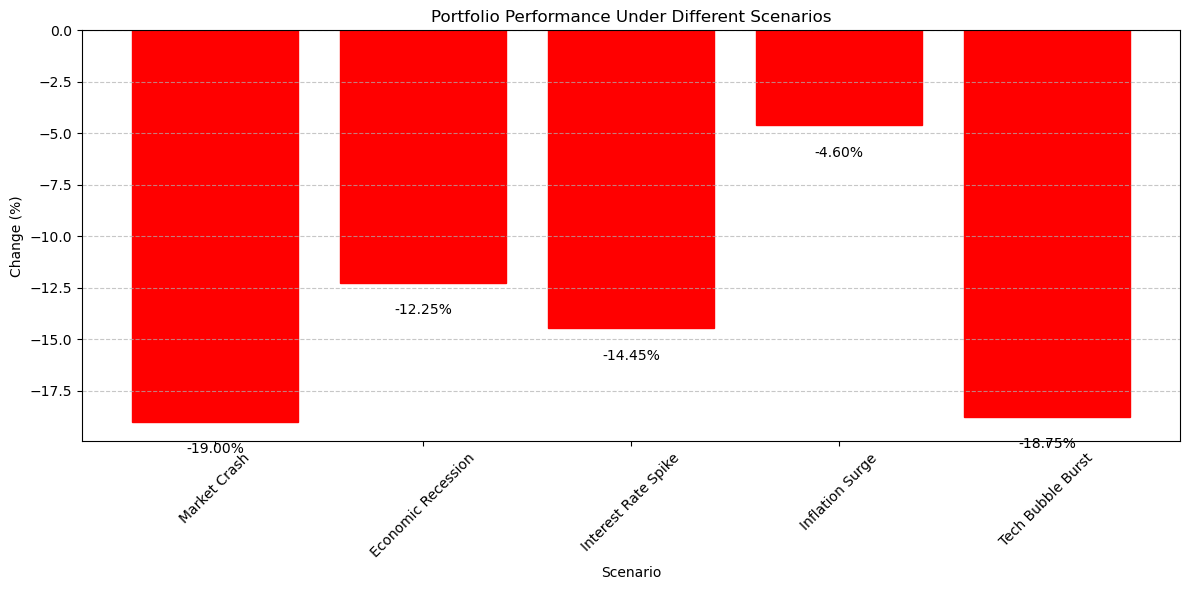

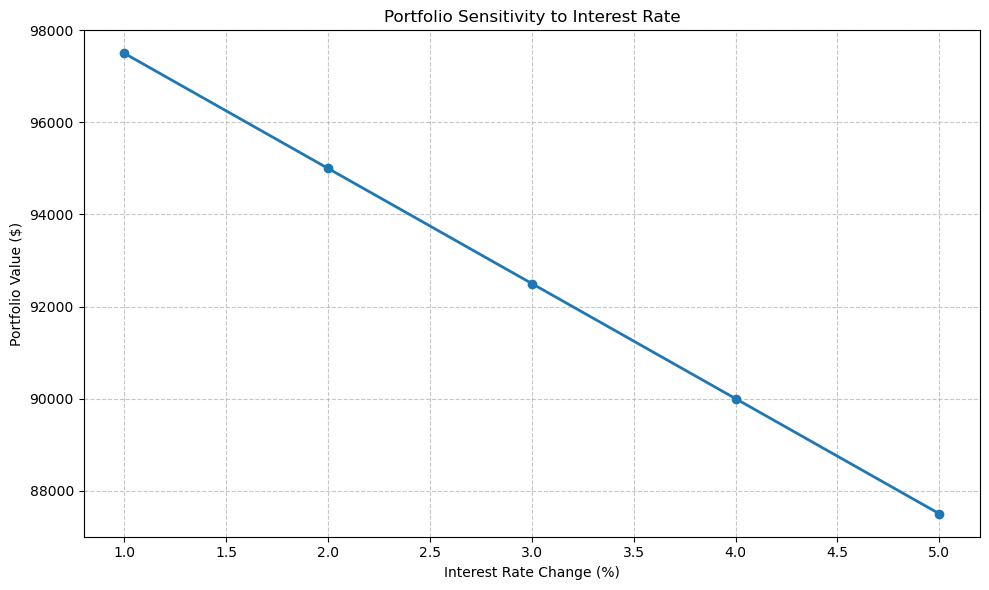

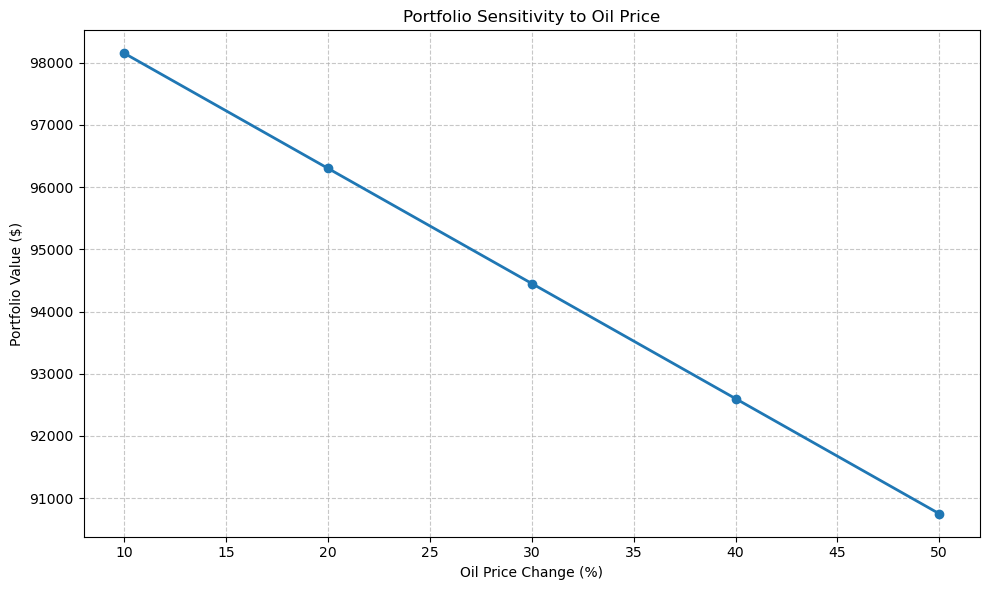

In [27]:
if __name__ == "__main__":
    main()